In [1]:
import os
import sys
import math
import random
import time
import numpy as np
import time

from skimage import morphology, measure
from skimage.color import label2rgb

import cv2
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow.python.platform import gfile

# load model

# new mobile fcn model, trained with half-sized images
# image size = (500, 1024) 
# trained width resizing = (None, img_size(0), img_size(1), 1) --> gray (not color)
# using proto-buffer file *.pb

In [4]:
model_dir = os.path.join('model', 'tf', 'test-16-1')
f = gfile.FastGFile(os.path.join(model_dir, 'mymodel.pb'), 'rb')

Instructions for updating:
Use tf.gfile.GFile.


In [5]:
sess = tf.Session()
graph_def = tf.GraphDef()
graph_def.ParseFromString(f.read())
sess.graph.as_default()
tf.import_graph_def(graph_def)

In [6]:
for i in tf.get_default_graph().get_operations():
    #if i.name.find('input') > -1:
    print(i.name)

import/output/ArgMax/dimension
import/output/concat/axis
import/output/concat/values_0
import/output/Slice/size
import/output/Sub/y
import/output/Rank
import/output/Sub
import/output/Slice/begin
import/upscore8/layer_biases
import/upscore8/layer_biases/read
import/upscore_8s/upscore8/upscore8/conv2d_transpose/output_shape/3
import/upscore8/weights
import/upscore8/weights/read
import/upscore_8s/strided_slice_2/stack_2
import/upscore_8s/strided_slice_2/stack_1
import/upscore_8s/strided_slice_2/stack
import/upscore_8s/strided_slice_1/stack_2
import/upscore_8s/strided_slice_1/stack_1
import/upscore_8s/strided_slice_1/stack
import/upscore_8s/strided_slice/stack_2
import/upscore_8s/strided_slice/stack_1
import/upscore_8s/strided_slice/stack
import/score_feed2/batch_normalization/moving_variance
import/score_feed2/batch_normalization/moving_variance/read
import/score_feed2/batch_normalization/moving_mean
import/score_feed2/batch_normalization/moving_mean/read
import/score_feed2/batch_normaliz

In [7]:
graph = tf.get_default_graph()
image = graph.get_tensor_by_name("import/input/Placeholder:0")
print(image)
is_training = graph.get_tensor_by_name("import/input/Placeholder_2:0")
print(is_training)

Tensor("import/input/Placeholder:0", shape=(?, 500, 1024, 1), dtype=float32)
Tensor("import/input/Placeholder_2:0", dtype=bool)


In [8]:
pred_annotation = sess.graph.get_tensor_by_name('import/output/ArgMax:0')
print(pred_annotation)

Tensor("import/output/ArgMax:0", shape=(?, ?, ?), dtype=int32)


# prepare test image

In [9]:
red = [255, 0, 0] # dent 
blue = [0, 0, 255] # dent
green = [0, 255, 0] # border
yellow = [255, 255, 0] # edge crack 
cyan = [0, 255, 255] # stain
pink = [255, 200, 200]
violet = [255, 0, 255]

back_ground, border_label, red_dent_label, blue_dent_label, stain_label, edge_crack_label, welding_hole_label, welding_line_label = 0, 1, 2, 3, 4, 5, 6, 7
dcolors = [(0, 0, 0), (0, 255, 0), (255, 0, 0), (0, 0, 255), (0, 255, 255), (255, 255, 0), [255, 200, 200], [255, 0, 255]]

label2name = {0:'bg', 1:'border', 2:'concave_dent', 3:'convex_dent', 4:'stain', 5:'edge_crack', 6:'welding_line', 7:'welding_hole'}

In [10]:
def print_name(labels):
    names = []
    for label in labels:
        if label > 0:
            names.append(label2name[label])
    print(names)

In [11]:
test_dir = r'D:\MyUsers\Haebin\model\haebin\images'
#test_dir = r'c:\MyUsers\Park\Data\sdd\3dnl\_defects\Stain'
#test_dir = r'c:\MyUsers\Park\Data\sdd\3dnl\_defects\EdgeCrack'
#test_dir = r'c:\MyUsers\Park\Data\sdd\3dnl\_defects\Welding'

test_list = [f for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f))]
print('test_list = ', len(test_list), test_list[0])

test_list =  3 3DNL_record_count_1601_12_10717.jpg


3DNL_record_count_1601_12_10717.jpg
(1000, 2048, 3) uint8 39 163


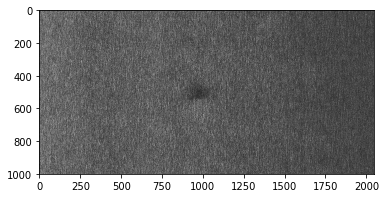

In [12]:
test_file = random.choice(test_list)
test_path = os.path.join(test_dir, test_file)
print(test_file)

img = cv2.imread(test_path, 1)
img = img[...,::-1] # bgr to rgb
print(img.shape, img.dtype, img.min(), img.max())
plt.imshow(img)
plt.show()

test =  (1, 500, 1024, 1) float32 41.0 152.0
deep time =  3.0596070289611816
pred =  (1, 500, 1024) int32
after squeeze =  (500, 1024) int32
pred =  [0 2]
['concave_dent']


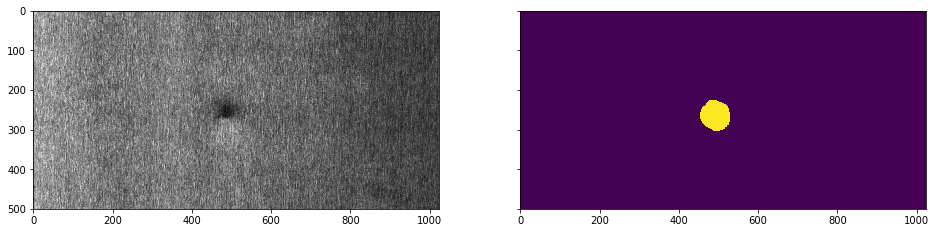

In [13]:
img = cv2.imread(test_path, 0)
test_img = cv2.resize(img, None, fx=0.5, fy=0.5).astype('float32')
test_img = np.expand_dims(test_img, axis=-1)
test_img = np.expand_dims(test_img, axis=0)
print('test = ', test_img.shape, test_img.dtype, test_img.min(), test_img.max())

start_time = time.time()
pred = sess.run([pred_annotation], feed_dict={image: test_img, is_training: False})
deep_time = time.time() - start_time
print('deep time = ', deep_time)

pred = pred[0]

print('pred = ', pred.shape, pred.dtype)
pred_img = np.squeeze(pred)
print('after squeeze = ', pred_img.shape, pred_img.dtype)

print('pred = ', np.unique(pred_img))
print_name(np.unique(pred_img))
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(16,12), sharex=True,sharey=True)
ax0.imshow(np.squeeze(test_img).astype('uint8'), cmap='gray')
ax1.imshow(pred_img)
plt.show()

#save pred_img
#cv2.imwrite('pred_img.png', pred)

pred_img =  (500, 1024) int32 [0 2]
['concave_dent']


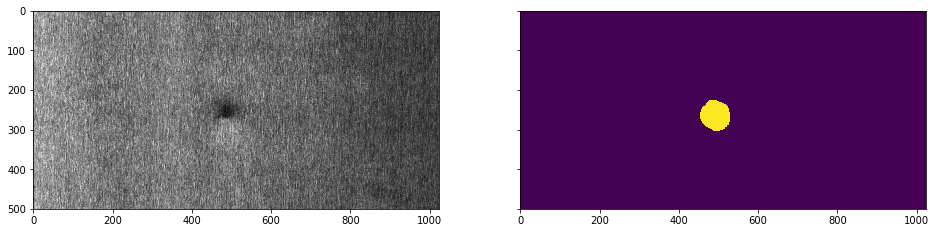

In [14]:
print('pred_img = ', pred_img.shape, pred_img.dtype, np.unique(pred_img))
print_name(np.unique(pred_img))
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(16,12), sharex=True,sharey=True)
ax0.imshow(np.squeeze(test_img).astype('uint8'), cmap='gray')
ax1.imshow(pred_img)
plt.show()

In [15]:
a = np.dstack([np.squeeze(test_img),np.squeeze(test_img),np.squeeze(test_img)])
a.shape

(500, 1024, 3)

pred_img =  (500, 1024) int32 [0 2]
['concave_dent']
x=453,y=226,w=76,h=79,a=4567
min=2,mean=2.0,max=2
class =  concave_dent


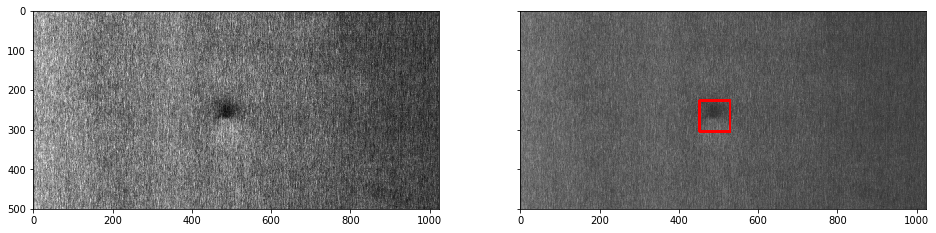

In [16]:
# just using labled deep learning output
print('pred_img = ', pred_img.shape, pred_img.dtype, np.unique(pred_img))
print_name(np.unique(pred_img))

regions = measure.regionprops(pred_img, pred_img)

overlay =  np.dstack([np.squeeze(test_img),np.squeeze(test_img),np.squeeze(test_img)]).astype('uint8')
for region in regions:
    label = region.label
    area = region.area
    min_ = region.min_intensity
    max_ = region.max_intensity
    mean_ = region.mean_intensity
    if area < 0:
        continue
    y0, x0, y1, x1 = region.bbox
    print('x={},y={},w={},h={},a={}'.format(x0, y0, x1-x0, y1-y0, area))
    print('min={},mean={},max={}'.format(min_, mean_, max_))
    print('class = ', label2name[min_])
    cv2.rectangle(overlay,(x0,y0),(x1,y1),dcolors[min_],5)
    
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(16,12), sharex=True,sharey=True)
ax0.imshow(np.squeeze(test_img).astype('uint8'), cmap='gray')
ax1.imshow(overlay)
plt.show()

# post processing

border blobs =  0


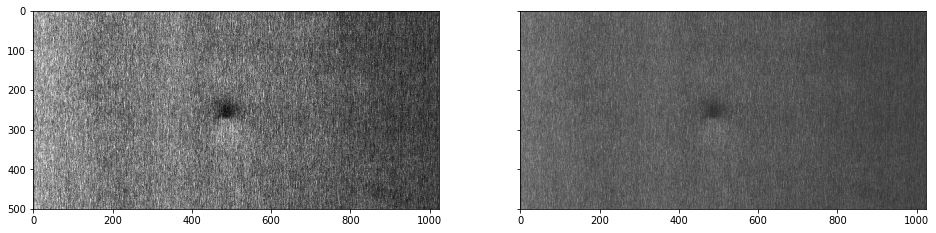

In [17]:
# to check border line, 
# bitwise_or of border_label and edge_crack_label
border_bool = (pred_img == border_label).astype('uint8')
edge_crack_bool = (pred_img == edge_crack_label).astype('uint8')
check_border = cv2.bitwise_or(border_bool, edge_crack_bool)

border_img = measure.label(check_border)
regions = measure.regionprops(border_img, pred_img)
print('border blobs = ', len(regions))
overlay =  np.dstack([np.squeeze(test_img),np.squeeze(test_img),np.squeeze(test_img)]).astype('uint8')
for region in regions:
    label = region.label
    area = region.area
    min_ = region.min_intensity
    max_ = region.max_intensity
    mean_ = region.mean_intensity
    if area < 0:
        continue
    y0, x0, y1, x1 = region.bbox
    print('x={},y={},w={},h={},a={}'.format(x0, y0, x1-x0, y1-y0, area))
    print('min={},mean={},max={}'.format(min_, mean_, max_))
    print('class = ', label2name[min_])
    cv2.rectangle(overlay,(x0,y0),(x1,y1),dcolors[min_],5)
    
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(16,12), sharex=True,sharey=True)
ax0.imshow(np.squeeze(test_img).astype('uint8'), cmap='gray')
ax1.imshow(overlay)
plt.show()

border blobs =  1
x=453,y=226,w=76,h=79,a=4567
min=2,mean=2.0,max=2
class =  concave_dent


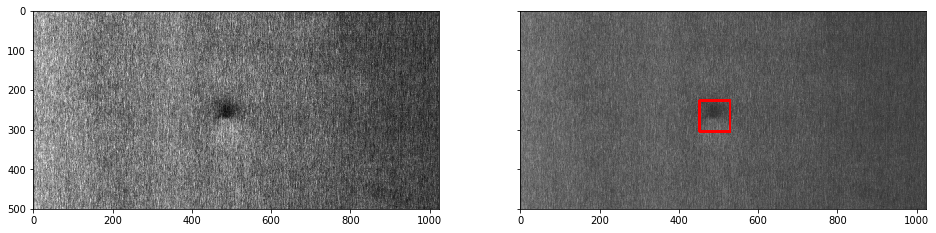

In [18]:
# find defects excluding boder lines
defects_img = pred_img.copy().astype('int32')
defects_img[pred_img == border_label] = 0

label_img = measure.label(defects_img)
regions = measure.regionprops(label_img, defects_img)
print('border blobs = ', len(regions))
overlay =  np.dstack([np.squeeze(test_img),np.squeeze(test_img),np.squeeze(test_img)]).astype('uint8')
for region in regions:
    label = region.label
    area = region.area
    min_ = region.min_intensity
    max_ = region.max_intensity
    mean_ = region.mean_intensity
    if area < 10:
        continue
    y0, x0, y1, x1 = region.bbox
    print('x={},y={},w={},h={},a={}'.format(x0, y0, x1-x0, y1-y0, area))
    print('min={},mean={},max={}'.format(min_, mean_, max_))
    print('class = ', label2name[min_])
    cv2.rectangle(overlay,(x0,y0),(x1,y1),dcolors[min_],5)
    
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(16,12), sharex=True,sharey=True)
ax0.imshow(np.squeeze(test_img).astype('uint8'), cmap='gray')
ax1.imshow(overlay)
plt.show()

# general way

In [19]:
# the rest defects
defects_

NameError: name 'defects_' is not defined

proc time =  0.014961957931518555


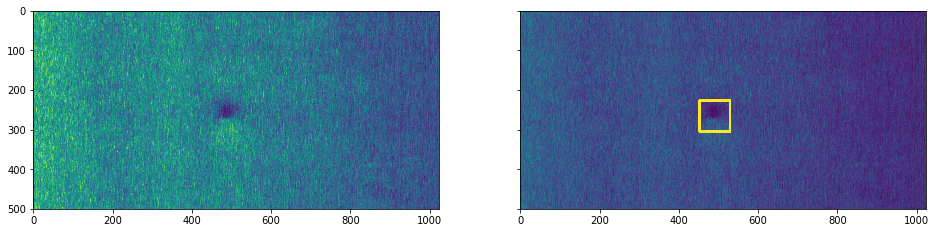

In [20]:
start_time = time.time()
bin_img = morphology.binary_closing((pred_img > 0), morphology.square(3))
label_img = measure.label(bin_img>0)
regions = measure.regionprops(label_img)
proc_time = time.time() - start_time
print('proc time = ', proc_time)

overlay = np.squeeze(test_img).copy().astype('uint8')
for region in regions:

    label = region.label
    area = region.area

    if area < 0:
        continue

    y0, x0, y1, x1 = region.bbox
    x = x0
    y = y0
    width = x1 - x0 - 1
    height = y1 - y0 - 1
    
    cv2.rectangle(overlay,(x0,y0),(x1,y1),(255,0,0),5)
    
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(16,12), sharex=True,sharey=True)
ax0.imshow(np.squeeze(test_img).astype('uint8'))
ax1.imshow(overlay)
plt.show()

In [21]:
start_time = time.time()
kernel = np.ones((3,3),np.uint8)
bin_img = (pred_img > 0).astype('uint8')
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel, iterations=3)
#bin_img = (pred > 0).astype('uint8')
print(bin_img.shape, bin_img.dtype, np.unique(bin_img))

_, cnts, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('blobs = ', len(cnts))
proc_time = time.time() - start_time
print('proc time = ', proc_time)

overlay = np.squeeze(test_img).copy().astype('uint8')
for i, cnt in enumerate(cnts):
    x,y,w,h = cv2.boundingRect(cnt)
    sbox = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(sbox)
    box = np.int0(box)
    sx,sy = sbox[0]
    sw, sh = sbox[1]
    sangle = sbox[2]
    #cv2.drawContours(overlay,[box],0,(255,0,0),1)
    cv2.rectangle(overlay,(x,y),(x+w,y+h),(255,0,0),5)

fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(16,12), sharex=True,sharey=True)
ax0.imshow(np.squeeze(test_img).astype('uint8'))
ax1.imshow(overlay)
plt.show()

(500, 1024) uint8 [0 1]


ValueError: not enough values to unpack (expected 3, got 2)

array([[595,  25],
       [595,  25],
       [595,  25],
       [595,  25]], dtype=int64)

In [18]:
# pre-processing: 
img_height, img_width = img.shape[:2]
bin_img = (pred == 2).astype('uint8') # 2:body
print(bin_img.shape, bin_img.dtype, np.unique(bin_img))

# find border region and from that false body region
border_img = (pred == 1).astype('uint8') # 2:border
print(border_img.shape, border_img.dtype, np.unique(border_img))
kernel = np.ones((3,3),np.uint8)
border_img = cv2.dilate(border_img, kernel, iterations = 5)
border_img[0, :] = 1
border_img[-1,:] = 1
border_img = ndi.binary_fill_holes(border_img).astype('uint8')
border_bg = np.zeros_like(border_img)
_, cnts, _ = cv2.findContours(border_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, cnt in enumerate(cnts):
    x,y,w,h = cv2.boundingRect(cnt)
    if w > img_width//3 and h > img_height //2:
        cv2.drawContours(border_bg,[cnt],0,1,-1)
        
# update bin_img
bin_img = cv2.bitwise_and(bin_img, border_bg)

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(pred)
ax[0].set_title('pred')
ax[1].imshow((pred == 2).astype('uint8'))
ax[1].set_title('bin_img')
ax[2].imshow(border_img)
ax[2].set_title('border_img')
ax[3].imshow(border_bg)
ax[3].set_title('border_bg')
ax[3].imshow(bin_img)
ax[3].set_title('after bin_img')

(1000, 2048) uint8 [0 1]
(1000, 2048) uint8 [0 1]


Text(0.5,1,'after bin_img')

In [12]:
# post-processing
ws_img, ws_bin = get_watershed(bin_img, 10)
ws_bin[ws_bin > 0] = 1

# expand watershed line for bing worked at cv2.findContours
kernel = np.ones((3,3),np.uint8)
e_ws_bin = cv2.erode(ws_bin, kernel,iterations = 1)

# only get watershe lines and remove blobs
xor_bin = np.bitwise_xor(bin_img, ws_bin)
# for removing watershed lines
xor_open = cv2.morphologyEx(xor_bin, cv2.MORPH_OPEN, kernel)

_, cnts, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
_, e_ws_cnts, _ = cv2.findContours(e_ws_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
_, xor_cnts, _ = cv2.findContours(xor_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output_bin = cv2.bitwise_or(e_ws_bin, xor_open)

_, cnts, _ = cv2.findContours(output_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('number labels = ', len(cnts))

overlay_img = img.copy()
for i, cnt in enumerate(cnts):
    x,y,w,h = cv2.boundingRect(cnt)
    sbox = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(sbox)
    box = np.int0(box)
    sx,sy = sbox[0]
    sw, sh = sbox[1]
    sangle = sbox[2]
    cv2.drawContours(overlay_img,[box],0,(255,0,0),1)

fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(bin_img)
ax[0].set_title('bin_img')
ax[1].imshow(ws_bin)
ax[1].set_title('ws_bin')
ax[2].imshow(e_ws_bin)
ax[2].set_title('e_ws_bin')
ax[3].imshow(xor_bin)
ax[3].set_title('xor_bin')
ax[4].imshow(xor_open)
ax[4].set_title('xor_open')
ax[5].imshow(overlay_img)
ax[5].set_title('overlay_img')
plt.show()

NameError: name 'get_watershed' is not defined

NameError: name 'bin_img' is not defined

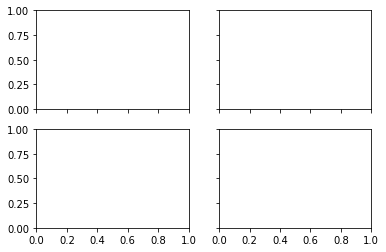

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(bin_img)
ax[0].set_title('bin_img')
ax[1].imshow(pred)
ax[1].set_title('pred')
ax[2].imshow(ws_bin)
ax[2].set_title('ws_bin')
ax[3].imshow(overlay_img)
ax[3].set_title('overlay_img')
plt.show()

In [79]:
watershed1_img, watershed1_bin = get_watershed(bin_img, 5)
watershed2_img, watershed2_bin = get_watershed(bin_img, 10)
watershed3_img, watershed3_bin = get_watershed(bin_img, 15)

watershed1_bin[watershed1_bin > 0] = 1
watershed2_bin[watershed2_bin > 0] = 1
watershed3_bin[watershed3_bin > 0] = 1

# watershed line (1 pixel)
ws_line1_img = watershed1_img == -1
ws_line2_img = watershed2_img == -1
ws_line3_img = watershed3_img == -1

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(bin_img)
ax[0].set_title('bin_img')
ax[1].imshow(watershed1_bin)
ax[1].set_title('watershed1_bin')
ax[2].imshow(watershed2_bin)
ax[2].set_title('watershed2_bin')
ax[3].imshow(watershed3_bin)
ax[3].set_title('watershed3_bin')
plt.show()

In [52]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(watershed1_bin)
ax[1].imshow(ws_line1_img)
ax[2].imshow(watershed2_bin)
ax[3].imshow(ws_line2_img)
plt.show()

In [34]:
_, cnts, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('number labels = ', len(cnts))

_, cnts1, _ = cv2.findContours(watershed1_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('number labels = ', len(cnts1))

_, cnts2, _ = cv2.findContours(watershed2_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('number labels = ', len(cnts2))

_, cnts3, _ = cv2.findContours(watershed3_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('number labels = ', len(cnts3))

number labels =  2072
number labels =  1733
number labels =  1103
number labels =  270


In [42]:
watershed1_bin.dtype

dtype('uint8')

In [44]:
xor0_1 = np.bitwise_xor(bin_img, watershed1_bin)

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(bin_img)
ax[1].imshow(watershed1_bin)
ax[2].imshow(xor0_1)
plt.show()

In [46]:
xor1_2 = np.bitwise_xor(watershed1_bin, watershed2_bin)

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(watershed1_bin)
ax[1].imshow(watershed2_bin)
ax[2].imshow(xor1_2)
plt.show()

In [36]:
xor2_3 = np.bitwise_xor(watershed2_bin, watershed3_bin)

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(watershed2_bin)
ax[1].imshow(watershed3_bin)
ax[2].imshow(xor2_3)
plt.show()

In [55]:
xor1_2_3 = cv2.add(xor1_2, xor2_3)

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(watershed1_bin)
ax[0].set_title('watershed1_bin')
ax[1].imshow(watershed2_bin)
ax[1].set_title('watershed2_bin')
ax[2].imshow(watershed3_bin)
ax[2].set_title('watershed3_bin')
ax[3].imshow(xor1_2_3)
ax[3].set_title('xor1_2_3')
plt.show()

In [63]:
kernel = np.ones((3,3),np.uint8)
watershed_line = cv2.subtract(xor1_2_3, cv2.dilate(cv2.erode(xor1_2_3, kernel, iterations = 1), kernel, iterations=2))

out_img = cv2.subtract(bin_img, watershed_line)

fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(watershed1_bin)
ax[1].imshow(watershed2_bin)
ax[2].imshow(watershed3_bin)
ax[3].imshow(watershed_line)
ax[4].imshow(out_img)
plt.show()

In [20]:
watershed_img, watershed_bin = get_watershed(bin2_img, 5)
print(watershed_img.shape, watershed_img.dtype)
print(watershed_bin.shape, watershed_bin.dtype)

sub_img = cv2.subtract(bin2_img, watershed_bin)

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(bin2_img)
ax[1].imshow(watershed_img)

plt.show()

(800, 4096) int32
(800, 4096) uint8


In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(bin2_img)
ax[1].imshow(watershed_img)

In [26]:
bin_img = (pred == 2).astype('uint8') # 2:body
bin2_img = get_watershed(bin_img, 5)

sub_img = cv2.subtract(bin_img, bin2_img)

# erode one-border lines
kernel = np.ones((3,3),np.uint8)
remain_img = cv2.erode(sub_img, kernel, iterations = 1)

# erod
erode2_img = cv2.erode(bin2_img, kernel, iterations = 1)

merge2_img = cv2.add(erode2_img, remain_img)


fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(bin_img)
ax[0].set_title('bin_img')
ax[1].imshow(bin2_img)
ax[1].set_title('bin2_img')
ax[2].imshow(sub_img)
ax[2].set_title('sub_img')
ax[3].imshow(remain_img)
ax[3].set_title('remain_img')
ax[4].imshow(merge2_img)
ax[4].set_title('merge2_img')
plt.show()

In [46]:
# multi_label watershed
dists = [0, 5, 10, 15]

multi_bins = []
for dist in dists:
    
    bin_img = (pred == 2).astype('uint8') # 2:body
    
    if dist == 0:
        multi_bins.append(bin_img)
        continue
    
    dist_img = ndi.distance_transform_edt(bin_img)
    sure_fg = (dist_img > dist).astype('uint8')
    
    #remove small sure regions
    kernel = np.ones((3,3),np.uint8)
    sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_OPEN, kernel)

    markers, num_marks = ndi.label(sure_fg)
    unknown = cv2.subtract(bin_img, sure_fg)
    markers = markers+1
    markers[unknown==1] = 0
    watershed_img = cv2.watershed(image=cv2.cvtColor(bin_img, cv2.COLOR_GRAY2RGB), markers=markers)
    
    watershed_bin = np.zeros(img.shape[0:2], dtype="uint8")
    watershed_bin[watershed_img < 1.5] = 0 
    watershed_bin[watershed_img > 1.5] = 255 

    # erode watershed line !
    #kernel = np.ones((3,3),np.uint8)
    #watershed_bin = cv2.erode(watershed_bin, kernel,iterations = 1)
    multi_bins.append(watershed_bin)
    
'''
overlab_bin = None
for i, bin_img in enumerate(multi_bins):
    if i == 0
        overlab_bin = bin_img.copy()
    overlap_bin[bin_img == 0 and overlab_bin != 0] = 0
'''
    
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(img)
ax[0].set_title('input image')
ax[1].imshow(multi_bins[0])
ax[1].set_title('bin with dist = {}'.format(dists[0]))
ax[2].imshow(multi_bins[1])
ax[2].set_title('bin with dist = {}'.format(dists[1]))
ax[3].imshow(multi_bins[2])
ax[3].set_title('bin with dist = {}'.format(dists[2]))
plt.show()

In [28]:
multi_bins[2].dtype

dtype('uint8')

In [43]:
bin_img = (pred == 2).astype('uint8') # 2:body
print('bin_img = ', bin_img.dtype, np.unique(bin_img))
distance = ndi.distance_transform_edt(bin_img)
sure_fg = (distance > 15).astype('uint8') #10
print('sure_fg = ', sure_fg.dtype, np.unique(sure_fg))

kernel = np.ones((3,3),np.uint8)
sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_OPEN, kernel)

markers, num_marks = ndi.label(sure_fg)
print('number of marks = ', num_marks)
print('markers = ', markers.dtype)

# watershed lines will be drawn on unknown region.
unknown = cv2.subtract(bin_img, sure_fg)
print('unknown = ', unknown.dtype, np.unique(unknown))

# add one to all labels so that sure background is not 0, but 1
markers = markers+1
# mark the region of unknown with zero
markers[unknown==1] = 0

# watershed requires color image
color_bin_img = cv2.cvtColor(bin_img, cv2.COLOR_GRAY2RGB)

watershed_img = cv2.watershed(image=color_bin_img, markers=markers)
print('watershed_img = ', watershed_img.dtype)
overlay_img = img.copy()
overlay_img[watershed_img == -1] = [50,50,50]

# for debugging 
overlap_bin = bin_img.copy()
overlap_bin[sure_fg > 0] = 2

bin_img =  uint8 [0 1]
sure_fg =  uint8 [0 1]
number of marks =  262
markers =  int32
unknown =  uint8 [0 1]
watershed_img =  int32


In [44]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(overlay_img, interpolation='nearest')
ax[0].set_title('input image')
ax[1].imshow(markers, interpolation='nearest')
ax[1].set_title('markers')
ax[2].imshow(overlap_bin, interpolation='nearest')
ax[2].set_title('overlap bin image')
ax[3].imshow(pred)
ax[3].set_title('deep prediction')
#ax[3].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
#ax[3].set_title('distance')
for a in ax:
    a.set_axis_off()
fig.tight_layout()
plt.show()

In [17]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20, 12), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, interpolation='nearest')
ax[0].set_title('input image')
ax[1].imshow(markers, interpolation='nearest')
ax[1].set_title('markers')
ax[2].imshow(unknown, interpolation='nearest')
ax[2].set_title('unknown')
ax[3].imshow(overlap_bin, interpolation='nearest')
ax[3].set_title('binary image')
ax[4].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[4].set_title('distance')
ax[5].imshow(overlay_img)
ax[5].set_title('watershed output')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [22]:
# -1: watershed line, 0: ??, 1: background, 2, ...: objects
print('watershed_img = ', np.unique(watershed_img))
plt.imshow(watershed_img)
plt.show()

watershed_img =  [  -1    0    1 ... 1041 1042 1043]


In [18]:
thresh = np.zeros(img.shape[0:2], dtype="uint8")
thresh[watershed_img < 1.5] = 0 # -1, 0, 1 --> 0
thresh[watershed_img > 1.5] = 255 # 2, .. --> 255

# erode watershed line !
kernel = np.ones((3,3),np.uint8)
thresh = cv2.erode(thresh,kernel,iterations = 1)

#save final binary image
cv2.imwrite('input_img.bmp', img[...,::-1])
cv2.imwrite('bin_img.bmp', thresh)

_, cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('number labels = ', len(cnts))

overlay_img = img.copy()
for i, cnt in enumerate(cnts):
    x,y,w,h = cv2.boundingRect(cnt)
    sbox = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(sbox)
    box = np.int0(box)
    sx,sy = sbox[0]
    sw, sh = sbox[1]
    sangle = sbox[2]
    cv2.drawContours(overlay_img,[box],0,(255,0,0),1)
    
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 14), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(overlay_img, interpolation='nearest')
ax[0].set_title('input image')
ax[1].imshow(markers, interpolation='nearest')
ax[1].set_title('markers')
ax[2].imshow(overlap_bin, interpolation='nearest')
ax[2].set_title('overlap bin image')
ax[3].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('distance')
for a in ax:
    a.set_axis_off()
fig.tight_layout()
plt.show()

cv2.imwrite('output_img.png', overlay_img[...,::-1])

number labels =  309


True